In [1]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
# https://github.com/keras-team/keras/issues/4278
# https://towardsdatascience.com/keras-hyperparameter-tuning-in-google-colab-using-hyperas-624fa4bbf673

# Hyperparameter optimization with talos

This notebook contains a bunch of experiments to optimize our model with a hyperparameter search algorithm.

## Import libraries and data

In [2]:
import pandas as pd
import ipynb.fs.defs.common as common

Using TensorFlow backend.


In [3]:
df = pd.read_csv('data/E0_processed.csv')
df = pd.read_csv('all_processed.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

It's my experience that leagues have their own characteristic set of data. Allthough we optimize across all leagues, the hyperas notebook will show that it might be better to only use data from one league.

In [4]:
train = df[:'2017']
val = df['2018':]

In [5]:
x_train, y_train = common.get_feables(train, normalize=True)
x_val, y_val = common.get_feables(val, normalize=True)

# Model definition

Here's the model definition that was used for custom metrics and custom loss functions.
This model is adapted for use with talos.

You can see that some parameters are now defined within the `params` parameter.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.layers import BatchNormalization

from keras_tqdm import TQDMNotebookCallback

from IPython.display import clear_output

from talos.model.layers import hidden_layers
from talos.model.normalizers import lr_normalizer
from talos.metrics.keras_metrics import fmeasure_acc

from talos import live

def bet_model(x_train, y_train, x_val, y_val, params):

    # next we can build the model exactly like we would normally do it
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    kernel_regularizer=regularizers.l1(0.001)))
    
    normalize = params['normalize']

    if normalize:
        model.add(BatchNormalization())

    nr_hidden_layers = params['nr_hidden_layers']

    for i in range(nr_hidden_layers):
        model.add(Dense(params['hidden_layers'],
                        kernel_regularizer=regularizers.l1(0.001)))
        if normalize:
            model.add(BatchNormalization())

    model.add(Dense(3, 
                    kernel_regularizer=regularizers.l1(0.001),
                    activation = 'softmax'
                   ))
       
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'],
                 metrics=['acc'])

    history = model.fit(x_train, y_train.clip(0,1),
                          batch_size=params['batch_size'],
                          epochs=params['epochs'],
                          verbose=0,
                          validation_data=(x_val, y_val.clip(0,1)),
                          callbacks=[TQDMNotebookCallback(show_inner=False)]
                         )
       
    clear_output()    
    
    # finally we have to make sure that history object and model are returned
    return history, model

Next, we need to set up our parameter space. For the moment, I will only define choices.

The first neuron will be 10, 15 or 20. We will try to perform batch normalization, and so one ...

In [7]:
# then we can go ahead and set the parameter space
p = {
    'first_neuron' : [10, 15, 20],
    'normalize': [False, True],
    'nr_hidden_layers' : [0, 1, 2],
    'hidden_layers': [10, 15, 20],
    'optimizer': ['rmsprop', 'adam', 'sgd'],
    'batch_size': [64, 256, 512],
    'epochs' : [50, 100, 200]
    }


Before we continue, let's first determine the number of experiments.

For tuples, we only need to count the last number.
For lists, the number of elements in the list is important.

In [8]:
def talos_nr_experiments(params):
    total = 1
    for k in params.keys():
        if isinstance(params[k], tuple):
            total = total * params[k][2]
        else:
            total = total * len(params[k])
    return total
print(talos_nr_experiments(p),'experiments')

1458 experiments


Because we only want to perform approximately 50 experiments, we downsample the grid with the following factor

In [9]:
50 / talos_nr_experiments(p)

0.03429355281207133

```
I have performed 4 experiments with talos, which are stored somewhere in the repo with the name bet_model_XX.zip
```

In [10]:
# and run the experiment
import talos as ta

%matplotlib inline
t = ta.Scan(x=x_train.values,
            y=y_train,
            model=bet_model,
            grid_downsample=0.034, 
            params=p,
            dataset_name='bet_model',
            experiment_no='04')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [11:17<00:00, 16.55s/it]


Following data is collected during the run.

In [11]:
t.data.head()

,round_epochs,val_loss,val_acc,loss,acc,first_neuron,normalize,nr_hidden_layers,hidden_layers,optimizer,batch_size,epochs
0,50,0.978115,0.542404,0.989525,0.530427,15,True,2,15,rmsprop,64,50
1,200,0.978393,0.540777,0.986889,0.531997,20,False,2,20,adam,512,200
2,50,0.981737,0.539353,0.990775,0.529991,20,False,1,20,rmsprop,64,50
3,100,0.968844,0.542201,0.980918,0.532956,10,True,2,20,adam,64,100
4,200,0.984770,0.540980,0.993673,0.531735,15,False,1,20,sgd,64,200


In [12]:
t.peak_epochs_df.head()

,val_loss,val_acc,loss,acc,acc_epoch,loss_epoch
1,47,35,48,41,0.000021,0.000013
2,199,34,197,59,0.000051,0.000019
3,48,34,49,21,0.000042,0.000030
4,98,57,95,65,0.000026,0.000021
5,199,53,199,190,0.000023,0.000015


In [13]:
t.details

random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
grid_downsample                   0.034
reduction_threshold                 0.2
reduction_metric                val_acc
reduce_loss                       False
experiment_name            bet_model_04
complete_time            05/28/19/21:05
x_shape                     (16387, 21)
y_shape                      (16387, 3)
dtype: object

# Reporting

We can also construct some reporting.

In [14]:
r = ta.Reporting(t)

In [15]:
r.high()

0.543827537213105

In [16]:
r.correlate('val_acc')

first_neuron       -0.185738
nr_hidden_layers    0.233878
hidden_layers       0.195025
batch_size         -0.250147
epochs              0.184396
Name: val_acc, dtype: float64

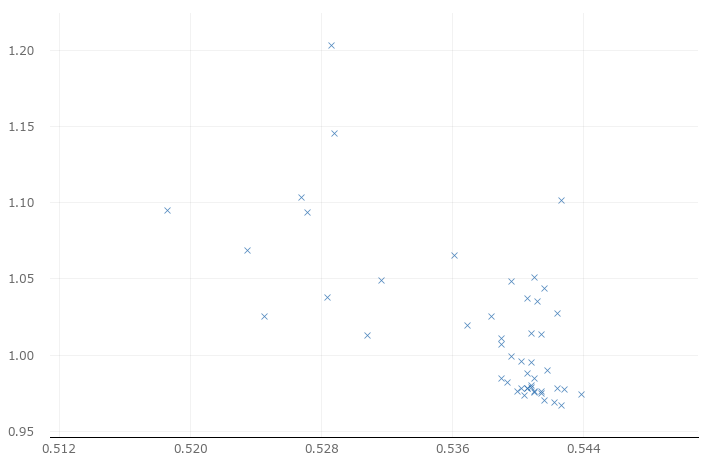

In [17]:
r.plot_regs()

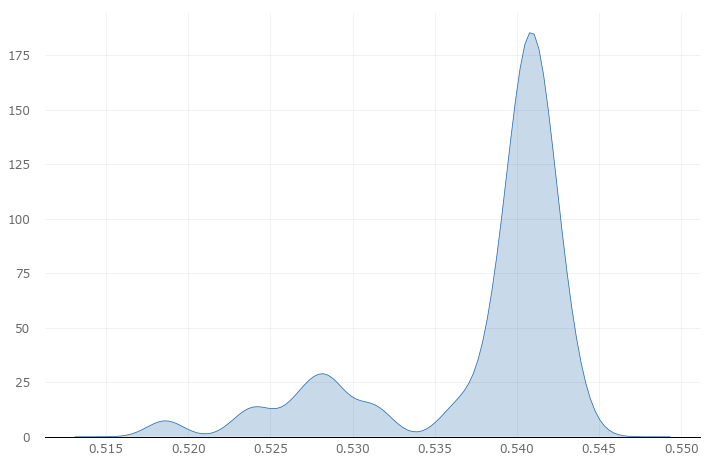

In [18]:
r.plot_kde('val_acc')

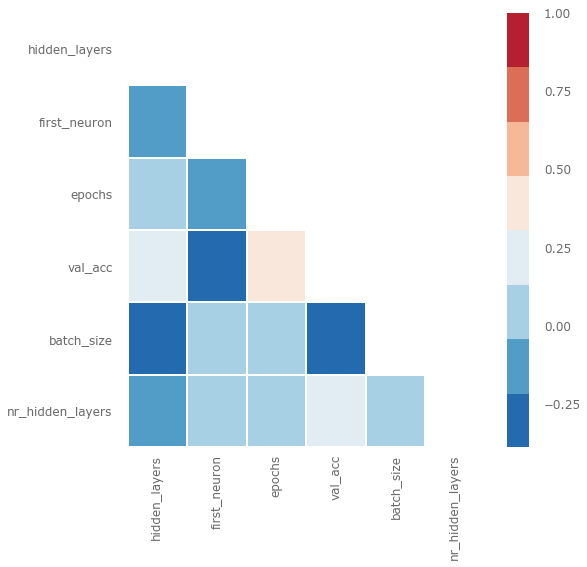

In [19]:
r.plot_corr(metric='val_acc')

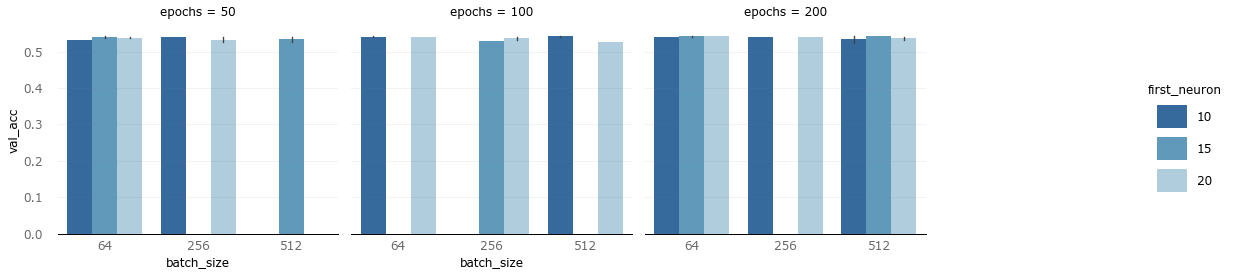

In [20]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'epochs')

# Saving model

This is easy in talos. In order to save the best model, you perform.

In [21]:
ta.Deploy(t, 'bet_model_04');

Deploy package bet_model_04 have been saved.


In [22]:
t = ta.Restore('bet_model_04.zip')

# Evaluate the model

In [23]:
odds = val[['odds-home','odds-draw','odds-away']]
r = (t.model.predict(x_val) > (1 / odds + 0.05))  * (odds * y_val - 1)
total = r.sum().sum()
cnt = (r != 0).sum().sum()
tdf = pd.Series([total, cnt, total/cnt], index=r.sum().index)
r_ = pd.concat([r.sum(), (r != 0).sum(), r.sum() / (r !=0).sum(), tdf],axis=1, ignore_index=True)
r_ .columns = ['Profit','Bets','Margins', 'Total']
display(r_)

,Profit,Bets,Margins,Total
odds-home,12.62,123,0.102602,-59.350000
odds-draw,-67.25,284,-0.236796,444.000000
odds-away,-4.72,37,-0.127568,-0.133671


In [28]:
odds = train[['odds-home','odds-draw','odds-away']]
r = (t.model.predict(x_train) > (1 / odds + 0.05)) * (odds * y_train - 1)
total = r.sum().sum()
cnt = (r != 0).sum().sum()
tdf = pd.Series([total, cnt, total/cnt], index=r.sum().index)
r_ = pd.concat([r.sum(), (r != 0).sum(), r.sum() / (r !=0).sum(), tdf],axis=1, ignore_index=True)
r_ .columns = ['Profit','Bets','Margins', 'Total']
display(r_)

,Profit,Bets,Margins,Total
odds-home,45.41,237,0.191603,-19.990000
odds-draw,-64.75,314,-0.206210,600.000000
odds-away,-0.65,49,-0.013265,-0.033317
